# Development of new features for polymerist

In [25]:
import networkx as nx
from rdkit import Chem

import mbuild
from mbuild.compound import Compound
from mbuild.conversion import load, load_smiles, from_rdkit, to_smiles, to_pybel
from mbuild.lib.recipes.polymer import Polymer

comp = mbuild.Compound()

## Developing monomer graphs

### String/graph translation (SMILES-like)

In [26]:
from polymerist.polymers.monographs import MonomerGraph
# from polymerist.polymers.smidgelib.smidgewrite import SMIDGEWriter
# from polymerist.polymers.smidgelib.smidgeread import SMIDGEReader

In [27]:
# test = f'{tests[-2]}.{tests[-2]}'
tests = [
    '[a]{-1}[A]({2-3}[Bee]{2=5}[C]{5=2}[Bee]{3-6}[Bee])({2-3}[Bee]({3-6}[Bee]){3-}[a]){-}[A]{2-2}[Bee]{3-6}[Bee]',
    '[A]{1-2}[B]{6=5}[C]{#}[D]',
]
seq = [1,1,1]
test = '.'.join(tests[i] for i in seq)
print(test)

[A]{1-2}[B]{6=5}[C]{#}[D].[A]{1-2}[B]{6=5}[C]{#}[D].[A]{1-2}[B]{6=5}[C]{#}[D]


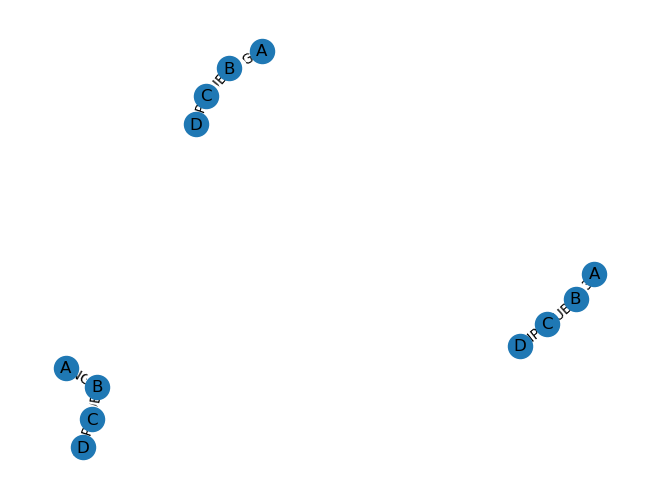

In [28]:
G = MonomerGraph.from_SMIDGE(test)
G.visualize()

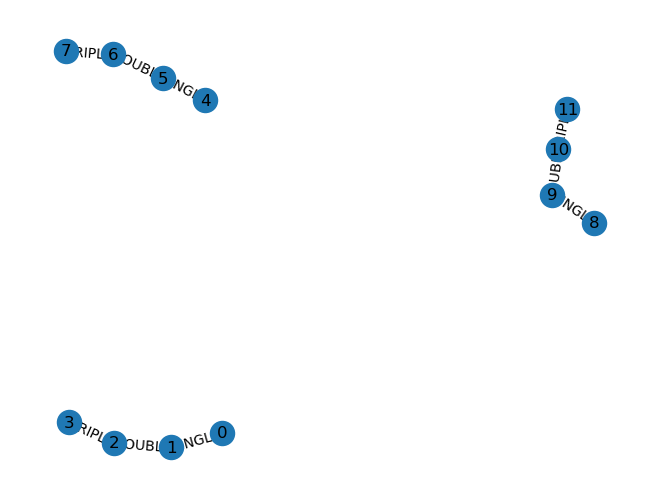

In [29]:
G.visualize(label_monomers=False)

In [30]:
res = G.to_SMIDGE(start_node_idxs=[7,10,1])
print(res)

[B]({2-1}[A]){6=5}[C]{#}[D].[D]{#}[C]{5=6}[B]{2-1}[A].[C]({5=6}[B]{2-1}[A]){#}[D]


### "Alphabet" of monomer fragment chemical information 

In [31]:
from typing import Optional
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from dataclasses import dataclass, field


from polymerist.genutils.fileutils.jsonio.serialize import JSONSerializable, TypeSerializer, MultiTypeSerializer
from polymerist.genutils.fileutils.jsonio.jsonify import make_jsonifiable, JSONifiable
from polymerist.polymers.monographs import MonomerGraph, MonomerGraphSerializer
from polymerist.rdutils.bonding.portlib import get_num_linkers


@dataclass
class MonomerFragmentInfo:
    '''Naming and in-line chemical encodings for a monomer unit within a polymer chain'''
    name   : str
    smiles : str
    smarts   : Optional[str] = field(default=None)
    category : Optional[str] = field(default=None)

    n_atoms       : int = field(init=False)
    functionality : int = field(init=False)
    contribution  : int = field(init=False)

    def __post_init__(self) -> None:
        tempmol = self.rdmol
        self.n_atoms = tempmol.GetNumAtoms()
        self.functionality = get_num_linkers(tempmol)
        self.contribution = self.n_atoms - self.functionality

    @property
    def rdmol(self) -> Chem.Mol:
        return Chem.MolFromSmiles(self.smiles, sanitize=False)

class MonomerFragmentInfoSerializer(TypeSerializer):
    python_type = MonomerFragmentInfo

    @staticmethod
    def encode(python_obj : MonomerFragmentInfo) -> dict[str, JSONSerializable]:
        return python_obj.__dict__

    @staticmethod
    def decode(json_obj : dict[str, JSONSerializable]) -> MonomerFragmentInfo:
        params = {k : v for k, v in json_obj.items() if k not in ('n_atoms', 'functionality', 'contribution')}
        return MonomerFragmentInfo(**params)

PolymerStructureSerializer = MultiTypeSerializer(MonomerGraphSerializer, MonomerFragmentInfoSerializer)
@make_jsonifiable(type_serializer=PolymerStructureSerializer)
@dataclass
class PolymerStructure:
    '''Encodes a multi-scale structural representation of a polymer topology'''
    monoinfo  : dict[str, MonomerFragmentInfo]
    monograph : MonomerGraph

    @property
    def node_info_map(self) -> dict[int, MonomerFragmentInfo]:
        '''Map from node indices to relevant monomer information'''
        return {
            node_id : self.monoinfo[alias]
                for node_id, alias in nx.get_node_attributes(self.monograph, self.monograph.MONOMER_NAME_ATTR).items()
        }

    def chem_info_is_compatible(self) -> bool:
        '''Validate whether the chemical information for monomer fragments is compatible with the structural graph'''
        if set(self.monoinfo.keys()) != self.monograph.unique_monomer_names:
            return False
        
        for node_id, degree in self.monograph.degree:
            if (degree != self.node_info_map[node_id].functionality):
                return False
        
        return True

ethane-1,2-diol_TERM


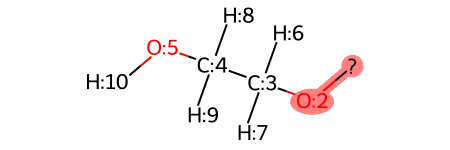

furan-2,5-dicarboxylic acid_TERM


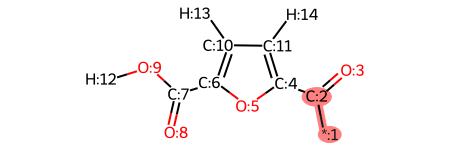

ethane-1,2-diol_MID


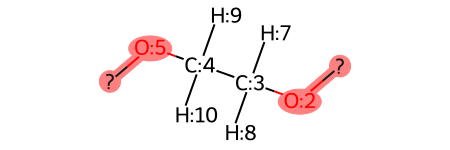

furan-2,5-dicarboxylic acid_MID


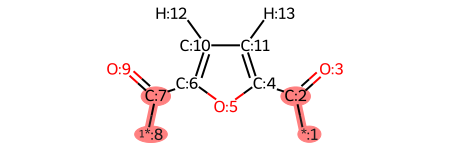

In [32]:
from string import ascii_uppercase 
from polymerist.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_ports


parent_monomers = {
    'ethane-1,2-diol' : 'OCCO',
    'furan-2,5-dicarboxylic acid' : 'O=C(O)c1ccc(C(=O)O)o1',
}
monomer_aliases = {
    mononame : lett*3
        for mononame, lett in zip(parent_monomers.keys(), ascii_uppercase)
}

monogrp = MonomerGroup.from_file('poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic acid).json')
moldict, monosmiles = {}, {}
for mononame, rdmol in monogrp.iter_rdmols():
    for i, port in enumerate(get_ports(rdmol)):
        rdmol.GetAtomWithIdx(port.linker.GetIdx()).SetIsotope(i)

    print(mononame)
    display(rdmol)
    moldict[   mononame] = rdmol
    monosmiles[mononame] = Chem.MolToSmiles(rdmol)

In [33]:
from polymerist.monomers import specification

mono_infos = {}
for mononame, smiles in monosmiles.items():
    parent_mononame = mononame.split('_')[0]
    parent_smiles = parent_monomers[parent_mononame]
    parent_alias  = monomer_aliases[parent_mononame]

    mono_info = MonomerFragmentInfo(
        name=mononame,
        smiles=smiles,
        smarts=specification.compliant_mol_SMARTS(smiles),
        category=parent_smiles,
    )
    alias = parent_alias.lower() if (mono_info.functionality == 1) else parent_alias.upper()
    mono_infos[alias] = mono_info
mono_infos

/home/timber/Documents/Python/polymerist_dev/polymerist/polymerist/monomers/specification.py:127: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn(f'Cleaned {num_repl} SMARTS atom query aberrations introduced by RDKit')
Cleaned 10 SMARTS atom query aberrations introduced by RDKit
/home/timber/Documents/Python/polymerist_dev/polymerist/polymerist/monomers/specification.py:127: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn(f'Cleaned {num_repl} SMARTS atom query aberrations introduced by RDKit')
Cleaned 14 SMARTS atom query aberrations introduced by RDKit
/home/timber/Documents/Python/polymerist_dev/polymerist/polymerist/monomers/specification.py:127: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn(f'Cleaned {num_repl} SMARTS atom query aberrations introduced by RDKit')
Cleaned 10 SMARTS atom query aberrations introduced by RDKit
/home/timber/Documents/Python/polymer

{'aaa': MonomerFragmentInfo(name='ethane-1,2-diol_TERM', smiles='[*:1][O:2][C:3]([C:4]([O:5][H:10])([H:8])[H:9])([H:6])[H:7]', smarts='[*:1]-[#8D2+0:2]-[#6D4+0:3](-[#6D4+0:4](-[#8D2+0:5]-[#1D1+0:10])(-[#1D1+0:8])-[#1D1+0:9])(-[#1D1+0:6])-[#1D1+0:7]', category='OCCO', n_atoms=10, functionality=1, contribution=9),
 'bbb': MonomerFragmentInfo(name='furan-2,5-dicarboxylic acid_TERM', smiles='[*:1][C:2](=[O:3])[C:4]1=[C:11]([H:14])[C:10]([H:13])=[C:6]([C:7](=[O:8])[O:9][H:12])[O:5]1', smarts='[*:1]-[#6D3+0:2](=[#8D1+0:3])-[#6D3+0:4]1=[#6D3+0:11](-[#1D1+0:14])-[#6D3+0:10](-[#1D1+0:13])=[#6D3+0:6](-[#6D3+0:7](=[#8D1+0:8])-[#8D2+0:9]-[#1D1+0:12])-[#8D2+0:5]-1', category='O=C(O)c1ccc(C(=O)O)o1', n_atoms=14, functionality=1, contribution=13),
 'AAA': MonomerFragmentInfo(name='ethane-1,2-diol_MID', smiles='[*:1][O:2][C:3]([C:4]([O:5][1*:6])([H:9])[H:10])([H:7])[H:8]', smarts='[*:1]-[#8D2+0:2]-[#6D4+0:3](-[#6D4+0:4](-[#8D2+0:5]-[1*:6])(-[#1D1+0:9])-[#1D1+0:10])(-[#1D1+0:7])-[#1D1+0:8]', category='

[aaa]{0-1}[BBB]{0-1}[AAA]{0-1}[BBB]{0-1}[AAA]{0-1}[BBB]{0-1}[AAA]{0-1}[bbb]


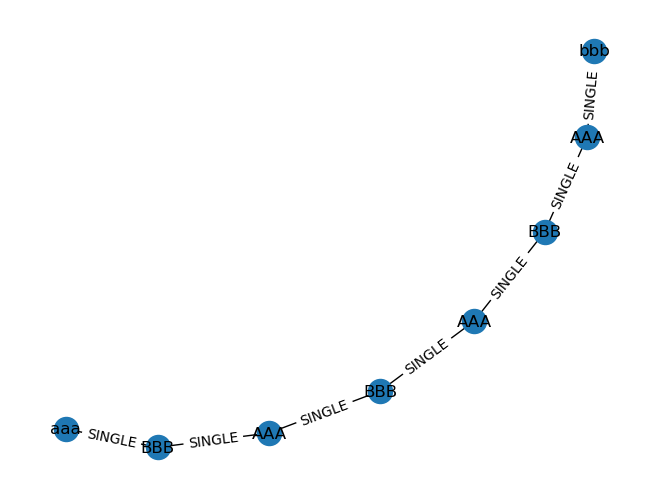

In [43]:
import networkx as nx
from polymerist.genutils.textual import delimiters
from polymerist.polymers.monographs import MonomerGraph

smidge = 'aBABABAb'
smidge = '{0-1}'.join(smidge)
smidge = delimiters.square_brackets_around_letters(smidge)
smidge = ''.join(3*c if c.isalpha() else c for c in smidge)
print(smidge)

monograph = MonomerGraph.from_smidge(smidge)
monograph.draw()

poly = PolymerStructure(
    monoinfo=mono_infos,
    monograph=monograph
)
poly.to_file('test.json')

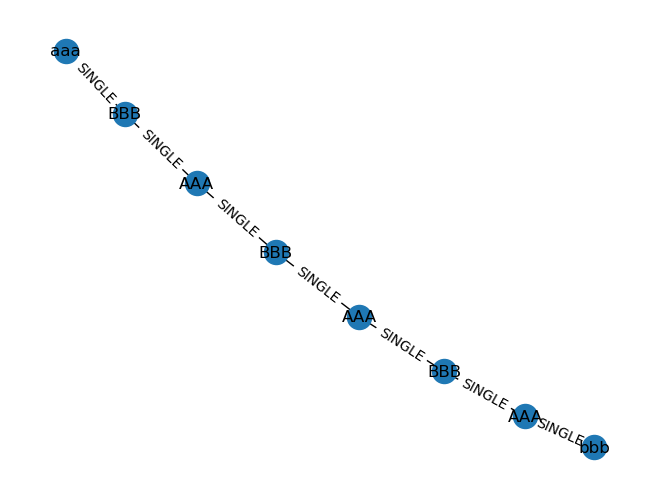

In [44]:
p = PolymerStructure.from_file('test.json')
p.monograph.draw()

In [45]:
for i in poly.monograph.termini:
    print(poly.monograph.nodes[i])

{'monomer_name': 'aaa', 'neighbor_flavors': {1: 0}}
{'monomer_name': 'bbb', 'neighbor_flavors': {6: 1}}


In [46]:
from polymerist.genutils.textual import ascii_printable

print(ascii_printable)

!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~


In [47]:
MONOMER_CHARS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
remap = {
    mononame : remap_char
        for (mononame, remap_char) in zip(poly.monoinfo.keys(), MONOMER_CHARS)
}
remap

{'aaa': 'a', 'bbb': 'b', 'AAA': 'c', 'BBB': 'd'}

In [49]:
from polymerist.genutils.textual.strsearch import shortest_repeating_substring


terms = list(monograph.termini)
assert(len(terms) == 2)
head_node = terms[0]

seq = ''
for i in nx.dfs_preorder_nodes(monograph, source=head_node):
    if i not in terms:
        mononame = monograph.nodes[i][monograph.MONOMER_NAME_ATTR]
        seq += remap[mononame]
min_seq = shortest_repeating_substring(seq)
seq, min_seq, seq.count(min_seq)

('dcdcdc', 'dc', 3)

In [ ]:
poly.chem_info_is_compatible()